图像直方图统计：是用来表示数字图像中亮度分布的直方图，标绘了图像中每个亮度值的像素个数。显然当我们需要整体分析图像的亮度分布的时候，直方图统计可以很直观的展现出具体分布情况

接下来介绍下cv中的API:<span style="color:blue;">calcHist(images,channels,mask,histSize,ranges,,hist,accumulate)</span>

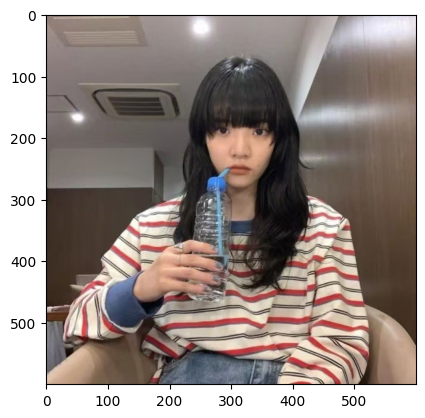

In [35]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
img1=cv.imread('D:\image\\aimyon.jpg')
plt.imshow(img1[:,:,::-1])

提醒下对于API中的imgs，channels，histsize,range都需要传入数组

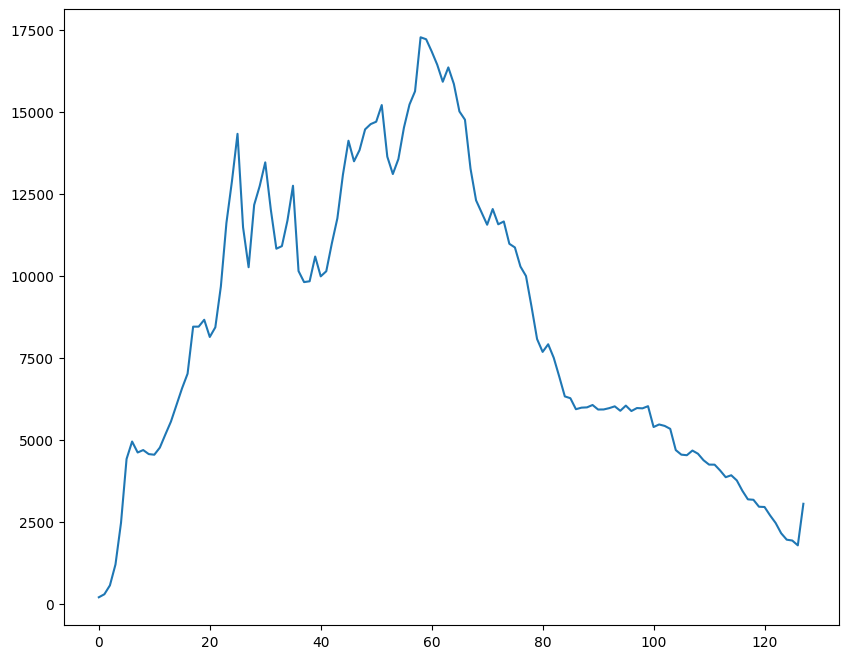

In [36]:
hist1=cv.calcHist([img1],[0],None,[128],[0,256])
hist2=cv.calcHist([img1],[1],None,[128],[0,256],hist1,accumulate=True)
hist3=cv.calcHist([img1],[2],None,[128],[0,256],hist1,accumulate=True)#当前统计的数据叠加到hist1数组
plt.figure(figsize=(10,8),dpi=100)
plt.plot(hist1)
plt.show()

对于实际的应用场景来说我们可能对图像的某些特定区域的亮度分布比较感兴趣，这个时候我们希望区域之外的像素点不参加统计，这个时候在整幅图像中提取出特定区域的技术就是掩模：

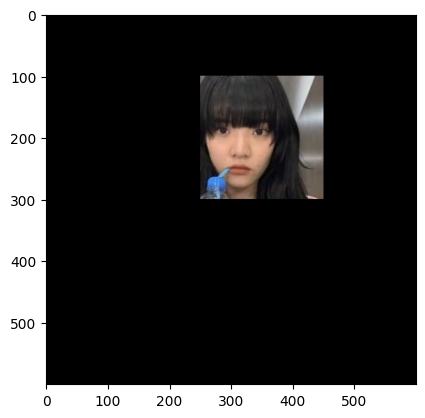

In [37]:
mask=np.zeros(img1.shape[:2],np.uint8)
mask[100:300,250:450]=255
img_masked=cv.bitwise_and(img1,img1,mask=mask)
plt.imshow(img_masked[:,:,::-1])

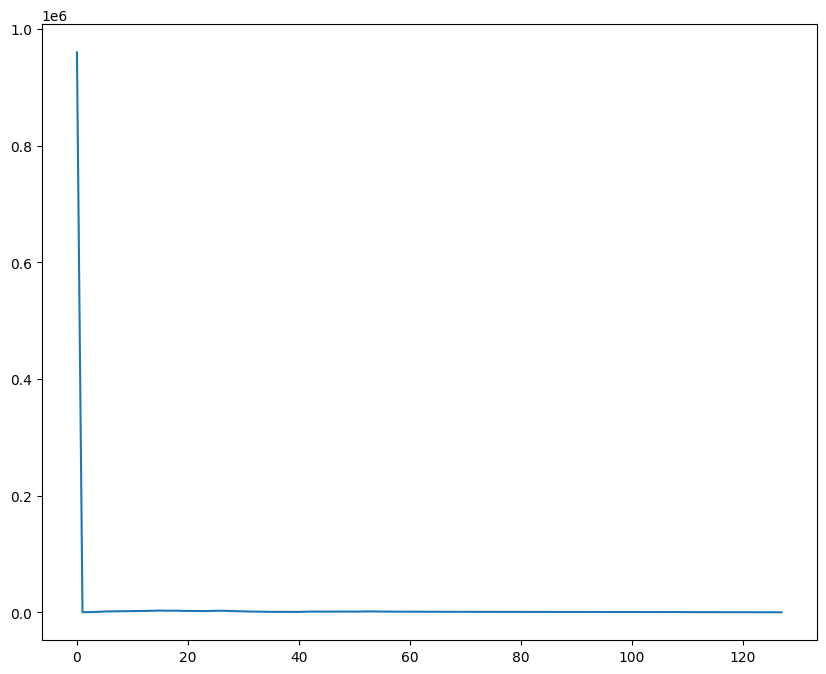

In [38]:

hist_mask=cv.calcHist([img_masked],[0],None,[128],[0,256])
cv.calcHist([img_masked],[1],None,[128],[0,256],hist_mask,True)
cv.calcHist([img_masked],[2],None,[128],[0,256],hist_mask,True)
plt.figure(figsize=(10,8),dpi=100)
plt.plot(hist_mask)
plt.show()

直方图均衡化：如果图像的灰度值集中在某个狭窄的范围内（例如整体偏暗或偏亮），会导致对比度低、细节模糊。例如：暗图像：灰度值集中在 0~50（低亮度区域）；亮图像：灰度值集中在 200~255（高亮度区域）。直方图均衡化通过拉伸灰度分布范围，让灰度值在 0~255 之间更均匀，从而增强明暗差异。直方图均衡化是一种用于增强图像对比度的经典图像处理技术，其核心思想是通过调整图像的灰度分布，使原本分布不均的灰度值尽可能均匀分布，从而让图像的细节更清晰。

核心原理
计算原始图像的灰度直方图：统计每个灰度值（0~255）的像素数量。
计算累积分布函数（CDF）：累计每个灰度值及之前所有灰度值的像素总数占比。
映射新灰度值：将原始灰度值通过 CDF 映射到新的灰度值（范围 0~255），公式为：
新灰度值 = round(CDF(原始灰度值) * 255)
（目的是将累积概率分布映射到 0~255 的灰度范围）

直方图均衡化的API：<span style="color:blue;">equalizeHist(img)</span>

注意此函数不能直接处理彩色图像，彩色图像每个像素包含多个通道（如 R、G、B），每个通道的灰度分布特性不同。如果直接对多通道图像应用均衡化，会破坏通道间的颜色相关性，导致严重的色彩失真（例如，原本的红色可能变成其他颜色）。

(<Axes: >, <matplotlib.image.AxesImage at 0x190acef0040>)

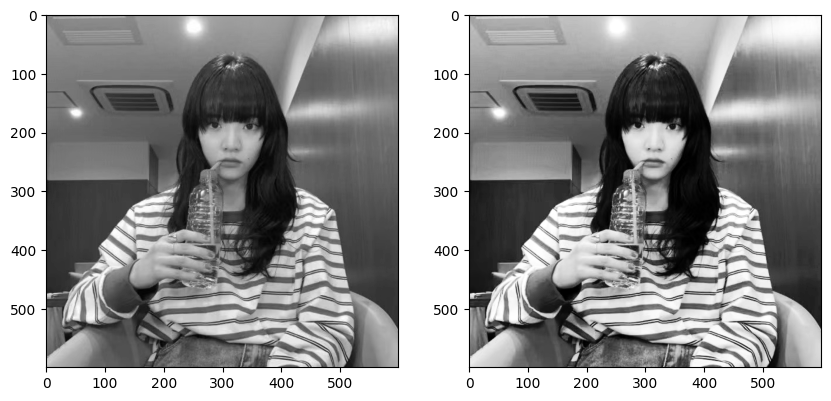

In [39]:
img1_gray=cv.imread('D:\image\\aimyon.jpg',0)
hist_1=cv.calcHist([img1_gray],[0],None,[128],[0,256])
img_equal=cv.equalizeHist(img1_gray)
hist_2=cv.calcHist([img_equal],[0],None,[128],[0,256])
plt.figure(figsize=(10,8),dpi=100)
plt.subplot(121),plt.imshow(img1_gray,'gray')
plt.subplot(122),plt.imshow(img_equal,'gray')



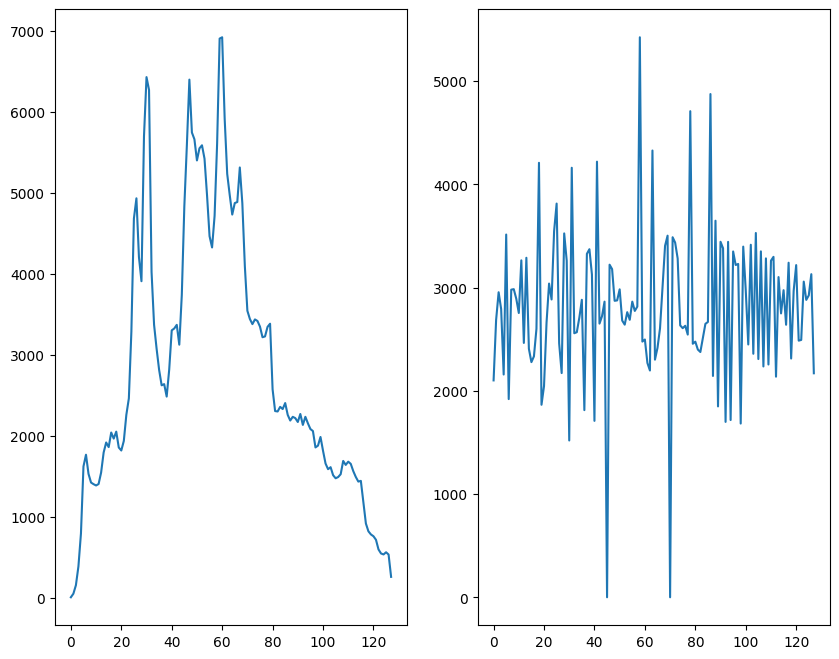

In [40]:
plt.figure(figsize=(10,8),dpi=100)
plt.subplot(121),plt.plot(hist_1)
plt.subplot(122),plt.plot(hist_2)
plt.show()

对于上面介绍的直方图均衡化是对全局图像进行的，所以可能导致局部细节丢失(如暗部纹理)，暗部和亮部容易过曝或者欠曝，所以对局部细节有要求的应用场景，我们不能用这种方法

自适应直方图均衡化：

这个方法将整个图像分割为几个子块，局部独立处理

我们可以设想一下如下情况，对于一个暗部细节区域在一个整体图像亮度都很高的图像之中，我们使用全局均衡化，明明暗部细节区域的像素值虽然在一个很小的范围之中，但是灰度值分布比较均匀，细节丰富，会变成一个细节全失的全暗区域(因为在全局图像的像素分布情况来说，此暗部细节区域只会被映射成灰度值几乎一样，在视觉上体现出来就是全黑),这就是欠曝，还有过曝的情况。但是我们使用自适应直方图均衡化，我们对这个局部区域进行均衡化的话，显然不会出现上面映射成同一个灰度值的情况，这样可以有效的避免丢失细节，甚至可以增强局部细节对比度。但是会引起局部噪声放大，因为噪声势必会引起局部灰度值极值的情况，这样进行局部均衡化后，会映射成灰度值极大的像素(产生亮斑)，原本相差不大的像素值，会因为映射导致差距显著拉大，放大了噪声。但是全局均衡化对噪声的放大的效果不明显。但是局部独立处理会导致各个分割子块的过渡并不顺滑，可能会有强烈割裂，所以需要插值运算，平滑图像

API:<span style="color:blue;">createCLAHE(clipLimit,tileGridSize)</span>

clipLimit:限制子块直方图中单个灰度级的最大像素数量，防止局部噪声被过度放大。当子块直方图中某灰度级的像素数超过 clipLimit 时，超出部分会被 “截断” 并均匀分配到其他灰度级，避免该灰度级在均衡化时被过度拉伸（比如暗区的少量噪声像素，若不限制会被拉成亮斑）。

tileGridSize:指定图像被分割的子块数量（行数 × 列数），决定局部处理的精细度

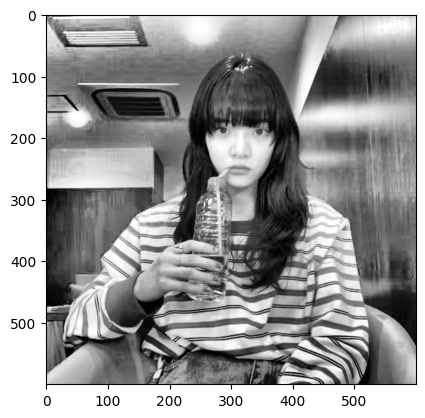

In [41]:
clahe=cv.createCLAHE(80,(5,5))
img_ahe=clahe.apply(img1_gray)
plt.imshow(img_ahe,'gray')